# Example of simulating (and detecting) Neanderthal introgression

Simulate 3% Neanderthal introgression into Europeans at 55 ky, lasting 25 years (i.e. one generation pulse of introgression), simulating 50 Mb sequence in total. Sample individuals on the European lineage at given time points and at the end, calculate some admixture statistics (if we care about them) and infer introgressed haplotypes for each sampled individual.

All output files will be generated with a common shared prefix.

```
./demography.py \
    --neand 55000,25,0,0.03 \
    --eur-ages `seq -s" " 45000 -2500 0` \
    --seq-len 100_000_000 \
    --stats direct indirect true_neand \
    --introgression neand-eur \
    --output-prefix example
```

(Note, that split times between populations are currently fixed.)

```
./demography.py --help
usage: demography.py [-h] [--eurA start,duration,rate1,rate2]
                     [--eurB start,duration,rate1,rate2]
                     [--afr start,duration,rate1,rate2]
                     [--neand start,duration,rate1,rate2]
                     [--Ne-nonafr NE_NONAFR] [--Ne-afr NE_AFR] --seq-len
                     SEQ_LEN
                     (--eur-ages EUR_AGES [EUR_AGES ...] | --neur NEUR)
                     [--nasn NASN] [--nafrA NAFRA] [--nafrB NAFRB]
                     [--introgression from-to] [--snps]
                     [--stats {true_neand,asc_neand,indirect,direct,afr_f4} [{true_neand,asc_neand,indirect,direct,afr_f4} ...]]
                     [--output-prefix FILE] [--debug]

optional arguments:
  -h, --help            show this help message and exit
  --eurA start,duration,rate1,rate2
                        EUR <-> AFR_A geneflow
  --eurB start,duration,rate1,rate2
                        EUR <-> AFR_B geneflow
  --afr start,duration,rate1,rate2
                        AFR_A <-> AFR_B geneflow
  --neand start,duration,rate1,rate2
                        nonAfr <-> Neanderthal geneflow
  --Ne-nonafr NE_NONAFR
  --Ne-afr NE_AFR
  --seq-len SEQ_LEN     Sequence length
  --eur-ages EUR_AGES [EUR_AGES ...]
                        Ages of European samples [years BP]
  --neur NEUR           Number of European chromosomes to simulate
  --nasn NASN           Number of Asian chromosomes to simulate
  --nafrA NAFRA         Number of AfrB chromosomes to simulate
  --nafrB NAFRB         Number of AfrA chromosomes to simulate
  --introgression from-to
                        Pair of populations for introgression detection
  --snps                Save all SNPs to a file
  --stats {true_neand,asc_neand,indirect,direct,afr_f4} [{true_neand,asc_neand,indirect,direct,afr_f4} ...]
                        Which statistics to calculate?
  --output-prefix FILE  Prefix of output files
  --debug               Debug info
  ```

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [7]:
hap_totals <-
    list.files(".", "*neand_haplotypes*") %>%
    seq_along %>%
    {. - 1} %>%
    map_dbl(function(i) {
        df <- read_tsv(paste0("example_eur", i, "_neand_haplotypes.tsv"), col_types = "dd")
        sum(df$end - df$start) / 50e6
    })

In [8]:
neand <- read_tsv("example_stats.tsv") %>% mutate(hap_neand = hap_totals)

Parsed with column specification:
cols(
  name = col_character(),
  age = col_double(),
  true_neand = col_double(),
  direct = col_double(),
  indirect = col_double()
)


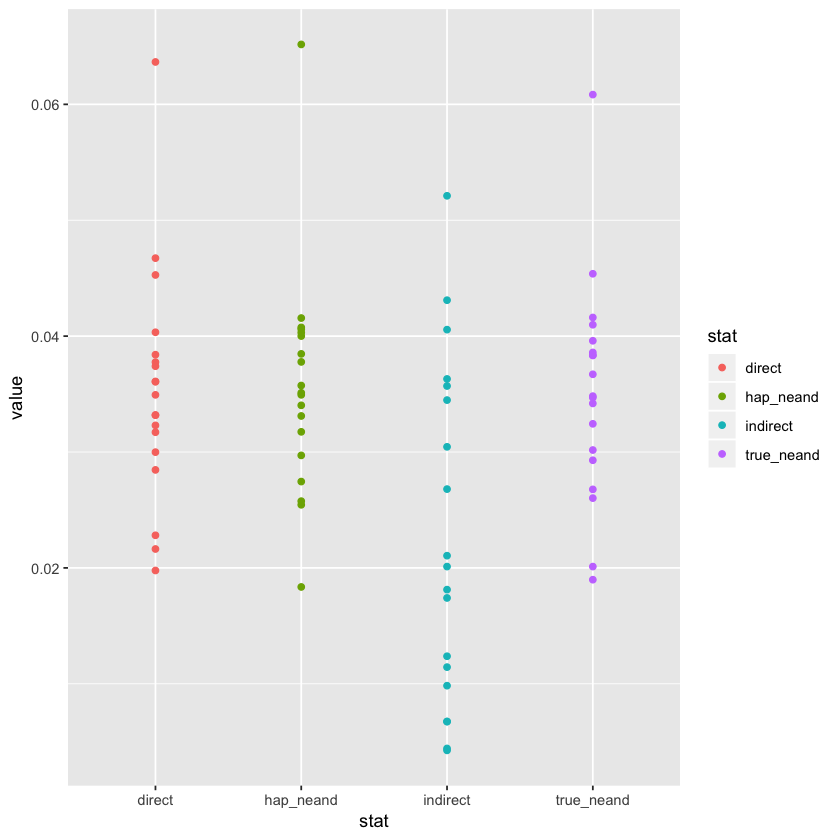

In [9]:
gather(neand, stat, value, -c(name, age)) %>%
    ggplot(aes(stat, value, color = stat)) + geom_point()

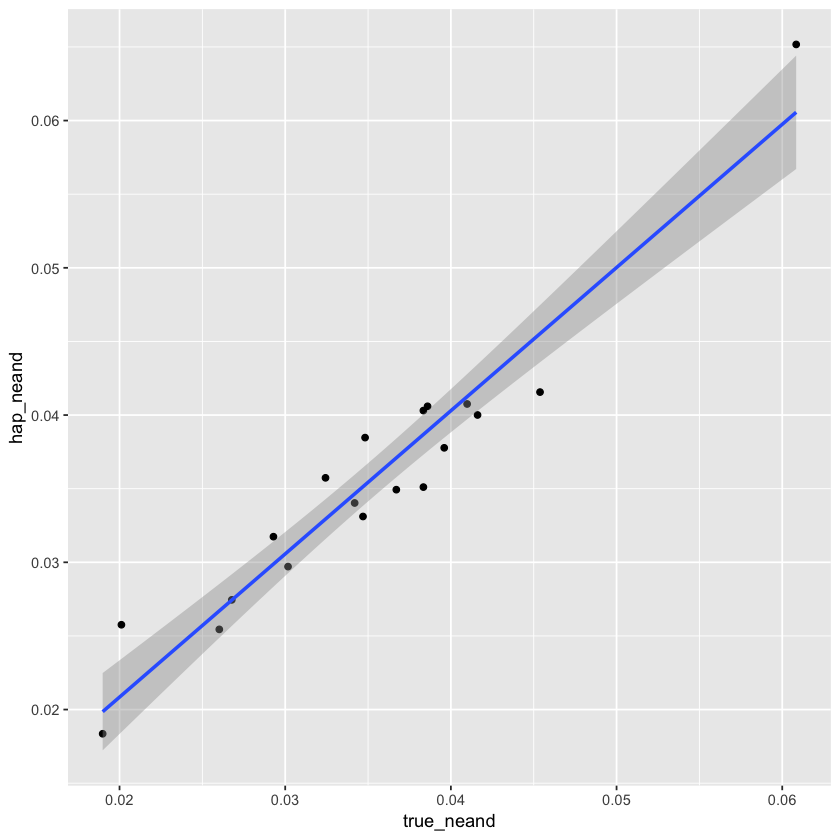

In [10]:
ggplot(neand, aes(true_neand, hap_neand)) + geom_point() +geom_smooth(method="lm")

In [20]:
haplotypes <-
    list.files(".", "*neand_haplotypes*") %>%
    seq_along %>%
    {. - 1} %>%
    map_dfr(~ read_tsv(paste0("example_eur", .x, "_neand_haplotypes.tsv"), col_types = "dd") %>%
                   mutate(len = end - start, ind = paste0("eur", .x)))

In [21]:
haplotypes %>% head

start,end,len,ind
8867896,8953146,85249.74,eur0
12117883,12423523,305639.68,eur0
14630273,15166779,536506.82,eur0
34925117,34995866,70749.30,eur0
44121702,44296283,174580.63,eur0
47712100,48462794,750694.24,eur0


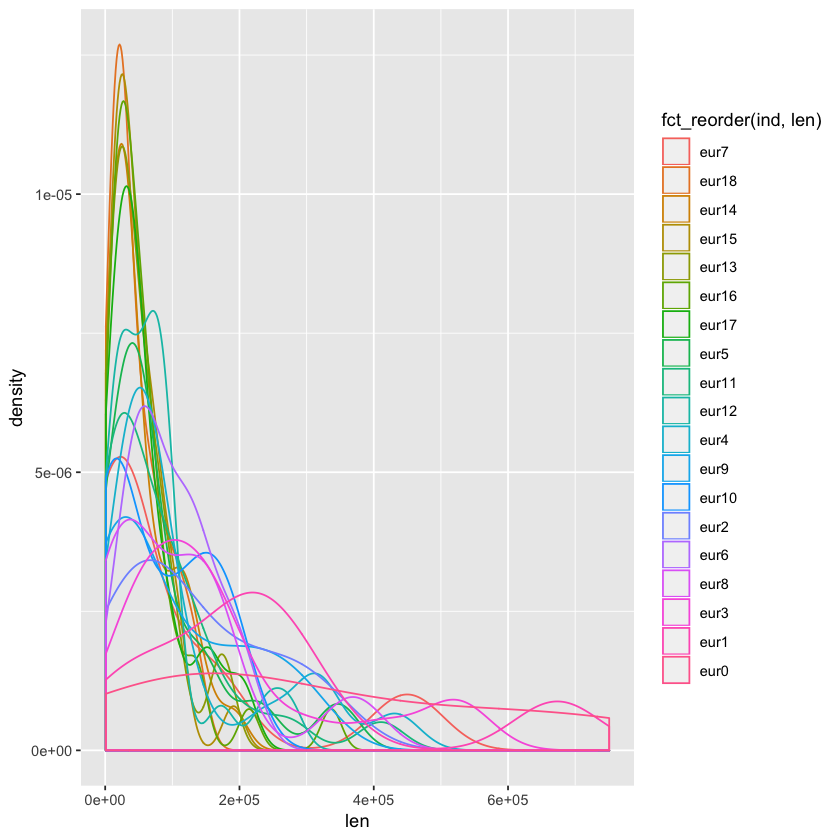

In [24]:
ggplot(haplotypes, aes(len, color = fct_reorder(ind, len))) + geom_density()